# Just for fun

This is just experimentation on the "Isolated Sign Language Recognition" dataset found [here](https://www.kaggle.com/competitions/asl-signs/data)

In this notebook, a data loader will be created to load the data and then some visualization will be applied. 

## Importing necessary libs

Python modules or scripts that reside in the '../src' directory need to be imported in this notebook. 
Following code will will add path to the beginning of the Python path list so that modules or scripts needed for a project which are not in the same directory as the main project file are accible.

In [1]:
import sys
sys.path.insert(0, '../src')

In [2]:
import torch
import torch.nn as nn
import os
import json
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import pyarrow.parquet as pq
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm

Following will import variables defined in a this config module. Specifically, it imports all the variables defined in config.py using the wildcard * operator.

The project related variables that will be imported are:

<b>DEVICE</b>: A string that represents the device used for training. It is either 'cuda' if a CUDA-enabled GPU is available or 'cpu' otherwise.</br>
<b>ROOT_PATH</b>: A string that represents the root directory path for the project.</br>
<b>SRC_DIR</b>: A string that represents the directory path for source files.</br>
<b>DATA_DIR</b>: A string that represents the directory path for data files.</br>
<b>MODEL_DIR</b>: A string that represents the directory path for model files.</br>
<b>CHECKPOINT_DIR</b>: A string that represents the directory path for checkpoint files.</br>
<b>RUNS_DIR</b>: A string that represents the directory path for TensorBoard log files.</br>
<b>OUT_DIR</b>: A string that represents the directory path for output files.</br>
<b>SEED</b>: An integer that represents the seed value for generating random numbers. It is set to 0 in this case.</br>

The model hyperparameters that will be imported are:
    
<b>BATCH_SIZE</b>: An integer that represents the batch size for the data loader.</br>
<b>LEARNING_RATE</b>: A float that represents the learning rate for the optimizer.</br>
<b>EPOCHS</b>: An integer that represents the number of epochs for training.</br>

The training data related variable that will be imported are:

<b>TRAIN_CSV_FILE</b>: Path of the training file `train.csv`.<br/>
<b>MAP_JSON_FILE</b>: Path of the map file `sign_to_prediction_index_map.json`.<br/>
<b>LANDMARK_FILES</b>: Root path of the landmark files `train_landmark_files`.<br/>

In [3]:
from config import *

Lets see where the data reside in config

In [4]:
DATA_DIR

'data/'

## ASL_DATSET Class

The ASL_DATSET class is a custom dataset class for loading sign Google Isolated Sign Language Recognition data in a specific format for training machine learning models.

### Class Variables

<b>sign_to_index</b>: A dictionary containing the mapping of sign names to their corresponding indices.<br/>
<b>data</b>: A Pandas DataFrame containing the data in CSV format, which includes the filename of the landmark data file, the sign name, and the video filename.<br/>
<b>landmark_dir</b>: The directory where the landmark data files are stored.<br/>

In [130]:
class ASL_DATSET(Dataset):
    def __init__(self, transform=None, max_seq_length=MAX_SEQUENCES):
        super().__init__()
        
        self.transform = transform
        self.load_datas()
        
        #[TODO] get this from data
        self.max_seq_length = max_seq_length
        
    def load_datas(self):
        
        # Read the Metadata CVS file for training data
        self.label_dict = json.load(open(os.path.join(ROOT_PATH,DATA_DIR,MAP_JSON_FILE)))
        
        # Read the Mapping JSON file to map target values to integer indices
        self.df_train = pd.read_csv(os.path.join(ROOT_PATH,DATA_DIR,TRAIN_CSV_FILE))
        
        # Generate Absolute path to locate landmark files
        self.file_paths = np.array([os.path.join(ROOT_PATH,DATA_DIR,x) for x in self.df_train["path"].values])
        
        # Store individual metadata lists
        # [TODO] Cleanup unnecessary files, do we need these?
        self.participant_ids = self.df_train["participant_id"].values
        self.sequence_ids = self.df_train["sequence_id"].values
        
        # keep tect signs and their respective indices
        self.signs = self.df_train["sign"].values
        self.targets = self.df_train["sign"].map(self.label_dict).values
        
    def __len__(self):
        return len(self.df_train)
    
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.item()
        
        # Get the file path for the single index
        landmark_file = self.file_paths[idx]
        
        # Read in the parquet file and process the data
        landmarks = pq.read_table(landmark_file).to_pandas()
        
        # Read individual landmark data
        # As per dataset description 'he MediaPipe model is not fully trained to predict depth so you may wish to ignore the z values'
        landmarks = landmarks[['frame', 'type', 'landmark_index', 'x', 'y']]
        
        landmarks = landmarks.pivot(index='frame', columns=['type', 'landmark_index'], values=['x', 'y'])
        landmarks.columns = [f"{col[1]}-{col[2]}_{col[0]}" for col in landmarks.columns]
        landmarks.reset_index(inplace=True)
        
        columns = list(landmarks.columns)
        new_columns = [columns[(i+1) // 2 + (len(columns) ) // 2 * ((i+1) % 2)] for i in range(1, len(columns))]
        landmarks=landmarks[new_columns].values.tolist()
        
        # Pad the landmark data
        pad_len = max(0, self.max_seq_length - len(landmarks))
        landmarks = landmarks + [[0]*len(new_columns)] * pad_len
        
        if self.transform:
            sample = self.transform(landmarks)
        
        sign   = self.signs[idx]
        target = self.targets[idx]
        
        sample = {'landmarks': landmarks, 'target': target}
        
        return sample
    
    def __repr__(self):
        return f'ASL_DATSET(Participants: {len(set(self.participant_ids))}, Unique signs: {len(self.label_dict)}), Length: {len(self.df_train)}'


In [131]:
dataset = ASL_DATSET()
dataset

ASL_DATSET(Participants: 21, Unique signs: 250), Length: 94477

## Data Loader

Create a DataLoader object, which will used to load data from a dataset object in batches during training or inference. 
The DataLoader object takes three arguments:

`dataset`: the dataset object containing the data to load.<br/>
`batch_size`: the number of samples to include in each batch.<br/>
`shuffle`: a Boolean value indicating whether to shuffle the order of the samples before loading them. If True, the samples will be randomly shuffled; if False, they will be loaded in their original order.<br/>

In [132]:
## ASL Data loader
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
len(dataloader)

94477

In [133]:
sample = next(iter(dataloader))
frames = sample['landmarks']
target = sample['target']

In [152]:
tuplized_frames = np.array([[[frame[i].item(), frame[i+1].item()] for i in range(0, len(frame), 2)] for frame in frames])

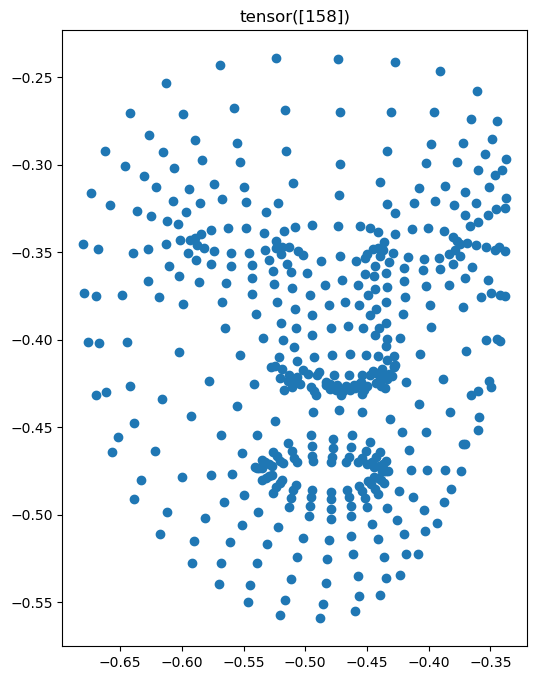

In [185]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

plt.figure(figsize=(6,8))
data = tuplized_frames[0][:FACE_FEATURES]
plt.scatter(-data[:,0], -data[:,1])
plt.title(target)
plt.show()

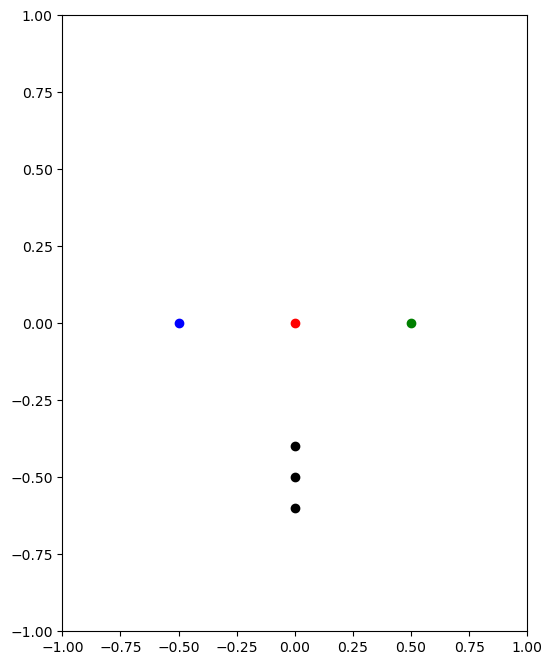

In [196]:
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(6, 8))

sc = ax.scatter([], [])
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])

# Define scatter plot elements for each body part
face_sc = ax.scatter(0, 0, c='r')
left_hand_sc = ax.scatter(-0.5, 0, c='b')
right_hand_sc = ax.scatter(0.5, 0, c='g')
pose_sc = ax.scatter([0, 0, 0], [-0.5, -0.4, -0.6], c='k')

def update(frame):
    # Get landmarks for each body part from sample data
    face_landmarks = frames[:FACE_FEATURES]
    #left_hand_landmarks = frame[1]
    #right_hand_landmarks = frame[3]
    #pose_landmarks = frame[2]

    # Update scatter plot with new landmark data
    sc.set_offsets([pose_landmarks[0], pose_landmarks[1]])
    face_sc.set_offsets(face_landmarks[:,0],face_landmarks[:,1])
    #left_hand_sc.set_offsets(left_hand_landmarks)
    #right_hand_sc.set_offsets(right_hand_landmarks)
    #pose_sc.set_offsets([[pose_landmarks[0], pose_landmarks[1]], [pose_landmarks[0], pose_landmarks[2]], [pose_landmarks[0], pose_landmarks[3]]])

    return sc, face_sc, left_hand_sc, right_hand_sc, pose_sc

# Define animation
ani = animation.FuncAnimation(fig, update, frames=tuplized_frames, interval=100)

# Show animation
plt.show()
